In [1]:
import xml.etree.ElementTree as ET

import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tqdm
from sklearn.model_selection import train_test_split
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
from IPython.display import Image

tf.get_logger().setLevel('ERROR')

## Формирование датасета

Датасеты: https://itnan.ru/post.php?c=1&p=516730

In [2]:
cloth_data = pd.read_csv('women-clothing-accessories.3-class.balanced.csv', sep='\t')
cloth_data.head()

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative


In [3]:
cloth_data.sentiment.value_counts()

negative    30000
positive    30000
neautral    30000
Name: sentiment, dtype: int64

In [4]:
pd_data = cloth_data[(cloth_data.sentiment == 'positive') | (cloth_data.sentiment == 'negative')].copy()
pd_data['positive'] = 0
pd_data.loc[pd_data.sentiment == 'positive', 'positive'] = 1

pd_data.positive.value_counts()

0    30000
1    30000
Name: positive, dtype: int64

In [5]:
train_reviews, validate_reviews, train_target, validate_target = train_test_split(pd_data.review.values, pd_data.positive.values, test_size=0.05)

In [6]:
BATCH_SIZE = 20

train_dataset = tf.data.Dataset.from_tensor_slices((
    [tf.convert_to_tensor(x, dtype=tf.string, name='inputs') for x in train_reviews[:6000]], 
    train_target[:6000],
)).batch(BATCH_SIZE)

validate_dataset = tf.data.Dataset.from_tensor_slices((
    [tf.convert_to_tensor(x, dtype=tf.string, name='inputs') for x in validate_reviews[:100]],
    validate_target[:100],
)).batch(BATCH_SIZE)

## Модель

In [7]:
BERT_ENCODER = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4'
BERT_PREPROCESSOR = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'

In [8]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(BERT_PREPROCESSOR, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(BERT_ENCODER, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [9]:
classifier_model = build_classifier_model()

## Дообучение на отзывах

In [10]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [11]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [12]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [13]:
history = classifier_model.fit(x=train_dataset,
                               validation_data=validate_dataset,
                               epochs=epochs)

Epoch 1/2
300/300 [==============================] - 1521s 5s/step - loss: 0.3439 - binary_accuracy: 0.8392 - val_loss: 0.1470 - val_binary_accuracy: 0.9400
Epoch 2/2
300/300 [==============================] - 1520s 5s/step - loss: 0.1631 - binary_accuracy: 0.9448 - val_loss: 0.0944 - val_binary_accuracy: 0.9500


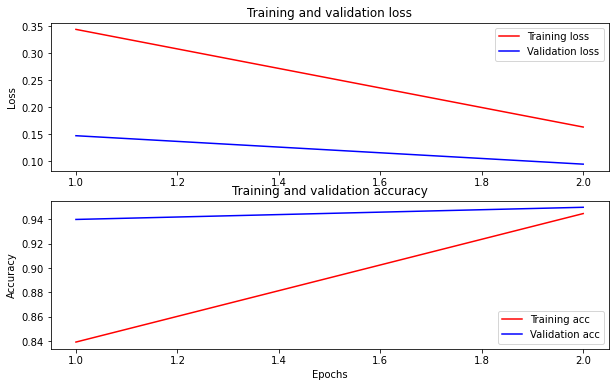

In [14]:
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [15]:
classifier_model.save('classifier_model', overwrite=True, include_optimizer=True)

## Оценка тестовой выборки

In [16]:
classifier = tf.keras.models.load_model('classifier_model', compile=False)

In [17]:
with open('test.csv', encoding='utf8') as fp:
    test_text = fp.read()

In [18]:
start_pos = 0
reviews = []

while True:
    open_pos = test_text.find('<review>', start_pos)
    if open_pos == -1:
        break
    
    close_pos = test_text.find('</review>', start_pos)
    review = test_text[open_pos + 8:close_pos]
    reviews.append(review.strip())
    start_pos = close_pos + 9

In [19]:
len(reviews)

100

In [20]:
result = [['Id', 'y']]
for idx, review in tqdm.tqdm(enumerate(reviews), total=len(reviews)):
    cur_eval = tf.sigmoid(classifier(tf.constant([review])))
    sentiment = 'pos'
    if cur_eval[0].numpy() < 0.5:
        sentiment = 'neg'
    result.append([idx, sentiment])

with open('my_result.csv', 'w') as fp:
    for col1, col2 in result:
        fp.write(f'{col1},{col2}\n')

100%|████████████████████████████████████████| 100/100 [00:13<00:00,  7.66it/s]


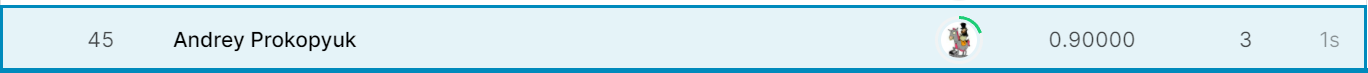

In [21]:
Image(filename='screen.png')